In [3]:
import numpy as np
import quimb.tensor as qtn

import jax
from jax import numpy as jnp
jax.config.update("jax_enable_x64", True)

In [4]:
num_sites = 9
chi = 30

#psi = qtn.MPS_rand_state(num_sites, chi, dtype=np.complex128, tags = ['PSI'])
psi = qtn.MPS_rand_state(num_sites, chi, tags = ['PSI'])
psi

/afs/cern.ch/user/m/mrobbian/.config/matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /tmp/matplotlib-yoo_at4x because there was an issue with the default path (/afs/cern.ch/user/m/mrobbian/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


MatrixProductState(tensors=9, indices=17, L=9, max_bond=30)

## MMD computation with tensor network formalism

The Maximum Mean Discrepancy (MMD) is a distance measure between two probability distributions based on the expectation values of a positive semi-definite kernel function $ K(x, y) $. In our context, it is used to compare the distribution $ q_\theta(x) $, generated by a quantum model, with a target distribution $ p(x) $ obtained from classical data. The data samples $ y $ are bitstrings, i.e., elements of the computational basis.

$$
\begin{aligned}
\operatorname{mmd}(\theta)=\; & \sum_{x \in \Omega} \sum_{y \in \Omega} q_{\theta}(x) K(x, y) q_{\theta}(y)
+ \sum_{x \in T} \sum_{y \in T} p(x) p(y) K(x, y)
- 2 \sum_{x \in \Omega} \sum_{y \in T} q_\theta(x) K(x, y) p(y)
\end{aligned}
$$

using the Born rule $ q_\theta(x) = |\braket{x | \psi}|^2 $.

$$
\begin{align*}
\min_{\theta} \left[ \operatorname{mmd}(\theta)\right] =
\min \bigg[ 
&\sum_{x, y \in \Omega} \braket{\psi | x} \braket{x | \psi} \, K(x, y) \braket{\psi | y} \braket{y | \psi}
- 2 \sum_{x \in \Omega} \sum_{y \in T} \braket{\psi | x} \braket{x | \psi} K(x, y) p(y) 
\bigg] =
\end{align*}
$$



We can manually contruct the TN that represents the sampling probabilities of the state $\ket{\psi}$. For example, for a single biststring $b = b_1\ldots b_n$, the probability of sampling it is given by

$$p(b) = |\langle\psi|\bm{b}\rangle|^2 = \langle\psi|b\rangle \langle b|\psi\rangle = \langle\psi|\Pi_{b}|\psi\rangle$$

where in the last equation we defined the projector $\Pi_b = |b\rangle\langle b|$ corresponding to bitstring $b$. Now, focus on a single qubit and imagine we put together in a list the projectors on state $\ket{0}$ and $\ket{1}$, thus obtaining

$$\Pi = [\Pi_0, \Pi_1], \quad \Pi_0 = |0\rangle\langle0|, \Pi_1 = |1\rangle\langle1|$$

This object $\Pi$ is a tensor of dimensions (2, 2, 2), and it is essentially a representation of the POVM corresponding to measuring in the computational basis $Z$. One can then construct a TN that encodes the sampling probabilities from state $\ket{\psi}$ by using the formula above 

$$p(b_1b_2\ldots b_n) = \langle\psi|\Pi_{b_1} \otimes \Pi_{b_2} \ldots \otimes \Pi_{b_n}|\psi\rangle$$

where each of the local $\Pi_b$ is the (2,2,2) tensors introduced above. Imporantly, this is a tensor networks where the open legs are the outcomes one $b_i$.
For a single-qubit space, measuring only in $Z$ basis, this corresponds to 
$$
\left[
\begin{array}{cc|cc}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1
\end{array}
\right]
$$

For each node of the tensor network. We can create the single node and put them together in an MPO

In [5]:
# Projector |0X0|
p0 = np.array([[1,0],[0,0]]) 
# Projector |1X1|
p1 = np.array([[0,0],[0,1]])
# POVM with elements {|0X0|, |1X1|}
comp_basis_povm = np.array([p0, p1])

# Create MPO representation of the POVM.
# Indices o{} are used to label the possible outcomes (in this case 0 and 1 for each qubit)
tensors = []
for i in range(num_sites):
    t = qtn.Tensor(comp_basis_povm,
                   inds=(f'o{i}', f'k{i}', f'b{i}'), 
                   tags = [f'I{i}', 'POVM'])
    tensors.append(t)

povm_tn = qtn.TensorNetwork(tensors)
povm_tn

TensorNetwork(tensors=9, indices=27)

The expression $ \, p(b_1b_2\ldots b_n) = \langle\psi|\Pi_{b_1} \otimes \Pi_{b_2} \ldots \otimes \Pi_{b_n}|\psi\rangle \,$
can be built as:

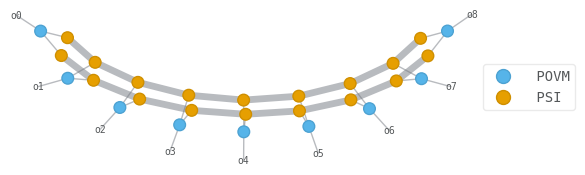

In [6]:
probs_tn = qtn.TensorNetwork([psi.H,
                              povm_tn, 
                              psi.reindex_sites('b{}')])

probs_tn.draw(color=['POVM', 'PSI'], show_tags=False)

The expression above become:

$$
\begin{align*}
= \min \left[
\sum_{x, y} \braket{\psi | \Pi | \psi} K(x, y) \braket{\psi | \Pi | \psi}
- 2 \sum_{x} \sum_{y} \braket{\psi | \Pi | \psi} K(x, y) p(y)
\right]
\end{align*}
$$


The kernel matrix $ K $ is defined as

$$
K = 
\begin{pmatrix}
1 & e^{-\frac{1}{2\sigma^2}} \\
e^{-\frac{1}{2\sigma^2}} & 1
\end{pmatrix}
$$

which encodes similarity between bitstrings using a Gaussian function. This matrix acts on the output space indexed by $ x $ and $ y $, and can be realized as a kernel MPO:

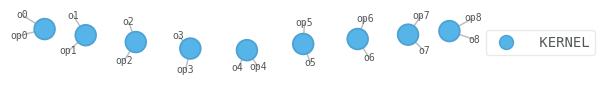

In [7]:
sigma = 0.5
fact = 1/(2*sigma**2)
kernel_mat = np.array([[1, fact],[fact, 1]])

# Kernel MPO
kernel_mpo = qtn.MPO_product_operator([kernel_mat]*num_sites,
                                      upper_ind_id = 'o{}', 
                                      lower_ind_id = 'op{}', # op stands for o prime, o'
                                      tags = ['KERNEL'])
kernel_mpo = kernel_mpo / kernel_mpo.norm()
kernel_mpo.draw(color=['KERNEL'],show_tags=False)

In full tensor index notation, the MMD becomes:

$$
\begin{aligned}
= \psi_b \, \Pi_k^{b, o} \, \psi^k \, K_{o}^{o'} \, \psi_b \, \Pi_k^{b, o'} \, \psi^k 
- 2\,\sum_B \left[ 
\psi^b \, \Pi_b^{ko} \, \psi_k \, K_{o}^{o'} \, B^o
\right]
\end{aligned}
$$

Here, $ \psi^k $ and $ \psi_b $ are the components of the quantum state $ \ket{\psi} $ and its dual $ \bra{\psi} $, respectively. Indices are placed according to the usual tensor convention: kets carry upper indices and bras lower indices. The operator $ \Pi $ is a tensor with indices $ \Pi_k^{b, o} $, encoding its action on both input and measurement bases. The sum over $ B $ denotes averaging over the target data bitstrings $ y $, with $ B^o $ representing the empirical frequency vector from data.

The first term can be built as:

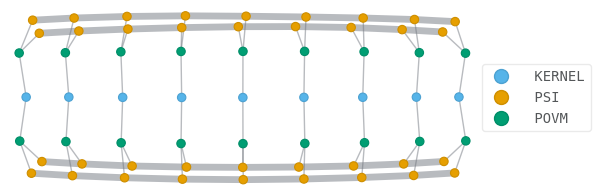

In [8]:
reindex_map = {f'o{i}': f'op{i}' for i in range(num_sites)}
overlap_tn = qtn.TensorNetwork([probs_tn, 
                                kernel_mpo,
                                probs_tn.reindex(reindex_map)])
overlap_tn.draw(color=['KERNEL', 'PSI', 'POVM'], show_tags=False)

In [9]:
overlap_tn

TensorNetwork(tensors=63, indices=94)

The second term needs the MPS representation of data. We are going to build a "computational MPS" for each bitstring in the dataset, which can be thought as the eigenstate that gives every time we sample the original bitstring. To compute efficiently the sum over the all possible bitstrings, we can group all the computational MPS in an hyperindexed tensor network, quimb will then sum over the hyperindex efficently.

In [10]:
from src.dataset_utils import bars_and_stripes, hypertn_from_data

bas = bars_and_stripes(int(np.sqrt(num_sites)), shuffle=False)
print(bas)

[[[0 0 1]
  [0 0 1]
  [0 0 1]]

 [[0 1 0]
  [0 1 0]
  [0 1 0]]

 [[0 1 1]
  [0 1 1]
  [0 1 1]]

 [[1 0 0]
  [1 0 0]
  [1 0 0]]

 [[1 0 1]
  [1 0 1]
  [1 0 1]]

 [[1 1 0]
  [1 1 0]
  [1 1 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [1 1 1]]

 [[0 0 0]
  [1 1 1]
  [0 0 0]]

 [[0 0 0]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [0 0 0]
  [0 0 0]]

 [[1 1 1]
  [0 0 0]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [0 0 0]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]]]


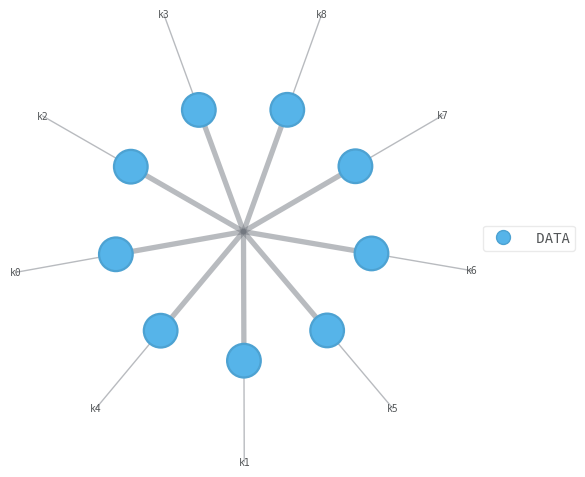

In [11]:
htn_data = hypertn_from_data(bas)
htn_data.draw(color=['DATA'], show_tags=False)

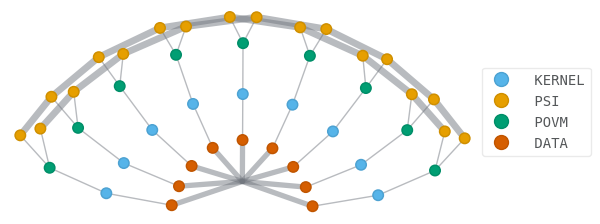

In [12]:
reindex_map = {f'k{i}': f'op{i}' for i in range(num_sites)}
overlap_data_tn = qtn.TensorNetwork([probs_tn, 
                                kernel_mpo,
                                htn_data.reindex(reindex_map) ])
overlap_data_tn.draw(color=['KERNEL', 'PSI', 'POVM', 'DATA'], show_tags=False)

In [13]:
overlap_data_tn

TensorNetwork(tensors=45, indices=61)

In [14]:
#overlap_data_tn.contract(output_inds=[], optimize='auto-hq')

We can build a single loss function to be minimized:

In [15]:
def mmd_loss(psi, povm_tn, kernel_mpo, htn_data):
    
    probs_tn = qtn.TensorNetwork([psi.H,
                              povm_tn, 
                              psi.reindex_sites('b{}')])
    
    reindex_map = {f'o{i}': f'op{i}' for i in range(num_sites)}
    model_tn = qtn.TensorNetwork([probs_tn, 
                                    kernel_mpo,
                                    probs_tn.reindex_(reindex_map)])
    
    reindex_map_op = {f'k{i}': f'op{i}' for i in range(num_sites)}
    overlap_data_tn = qtn.TensorNetwork([probs_tn, 
                                    kernel_mpo,
                                    htn_data.reindex_(reindex_map) ])
    
    reindex_map_o = {f'k{i}': f'o{i}' for i in range(num_sites)}
    data_tn = qtn.TensorNetwork([htn_data.reindex_(reindex_map_o), 
                                    kernel_mpo,
                                    htn_data.reindex_(reindex_map_op)])
    
    return model_tn.contract(output_inds=[], optimize='auto-hq').real - 2*overlap_data_tn.contract(output_inds=[], optimize='auto-hq').real + data_tn.contract(output_inds=[], optimize='auto-hq').real

log:
- with nothing normalized samples are all black
- if povm_tn is normalized all black
- works with both kernel and htn normalized

In [16]:
print(psi.norm())
print(povm_tn.norm())
print(kernel_mpo.norm())
print(htn_data.norm())

1.0
22.627416997969522
1.0000000000000002
3.7416573867739413


## KLD computation with tensor network formalism

$$
D_{KL}(P \| Q) = \sum_x P(x) \log \frac{P(x)}{Q_\theta(x)},
$$
where $P(x)$ is the target distribution, and $Q_\theta(x)$ is the model's distribution parameterized by $\theta$.
$$
= \sum_x P(x) \log P(x) - \sum_x P(x) \log Q_\theta(x).
$$
The only meaningful term for gradient over $\theta$ calculation is the second one, the negative-log-likelyhood. 

In [17]:
def nnl_loss(psi, htn_data):
    """
    Calculate the KL divergence between the MPS and the dataset.
    """
    loss = (psi | htn_data).contract(output_inds = ['hyper'], optimize = 'auto-hq').data
    
    return -1. * jnp.mean(jnp.log(jnp.abs(loss) ** 2))

## Optimization

In [18]:
loss_list = []
def callback_kl(tnopt):
    """Callback to compute the actual KL divergence loss."""
    psi = tnopt.get_tn_opt()
    loss = nnl_loss(psi, htn_data)
    loss_list.append(loss)


In [19]:
loss_list = []
def callback_mmd(tnopt):
    """Callback to compute the actual KL divergence loss."""
    psi = tnopt.get_tn_opt()
    loss = mmd_loss(psi, povm_tn, kernel_mpo, htn_data)
    loss_list.append(loss)
    return loss

In [ ]:
tnopt = qtn.TNOptimizer(
                    tn = psi,
                    # loss_fn=mmd_loss,
                    # loss_constants={"povm_tn":povm_tn, "kernel_mpo":kernel_mpo, "htn_data":htn_data},
                    loss_fn=nnl_loss,
                    loss_constants={"htn_data":htn_data},
                    loss_kwargs={},
                    norm_fn=lambda x: x / x.norm(),
                    autodiff_backend='jax',
                    jit_fn=True,
                    optimizer='adam',
                    # callback=callback_kl,
                    callback=callback_mmd,
                    )
iterations = 500
psi_opt = tnopt.optimize(iterations)

  0%|          | 0/500 [00:00<?, ?it/s]

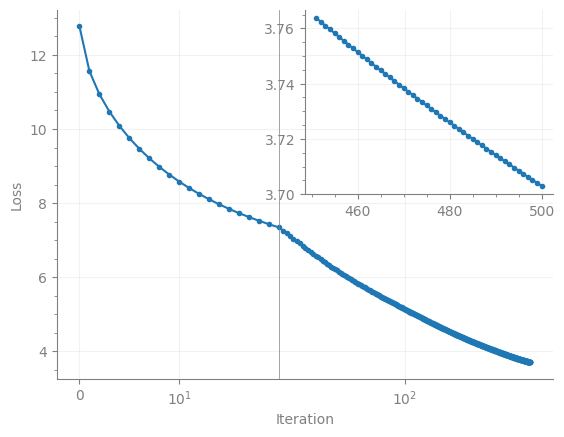

In [ ]:
fig, ax = tnopt.plot()
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
fig.savefig('plot.pdf', facecolor='white')      #with open('tensor_network.pkl', 'wb') as f: pickle.dump(psi_opt, f)

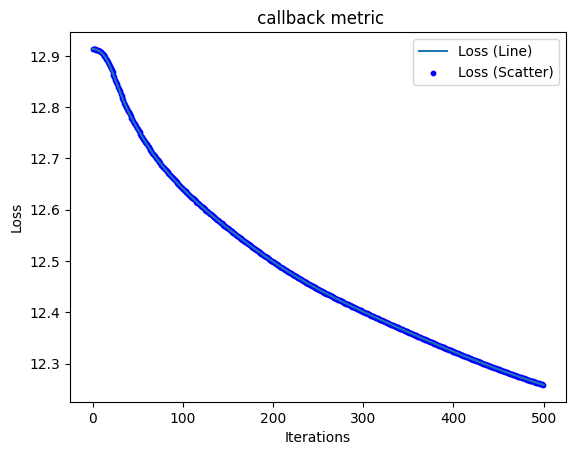

In [ ]:
# Plotting loss from loss_list
import matplotlib.pyplot as plt

# Line plot
plt.plot(loss_list, label='Loss (Line)')

# Scatter plot
plt.scatter(range(500), loss_list[:500], color='blue', s=10, label='Loss (Scatter)')

# Adding labels and title
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title(' callback metric')
plt.legend()

# Show the plot
plt.show()

Sampling from the optimized state

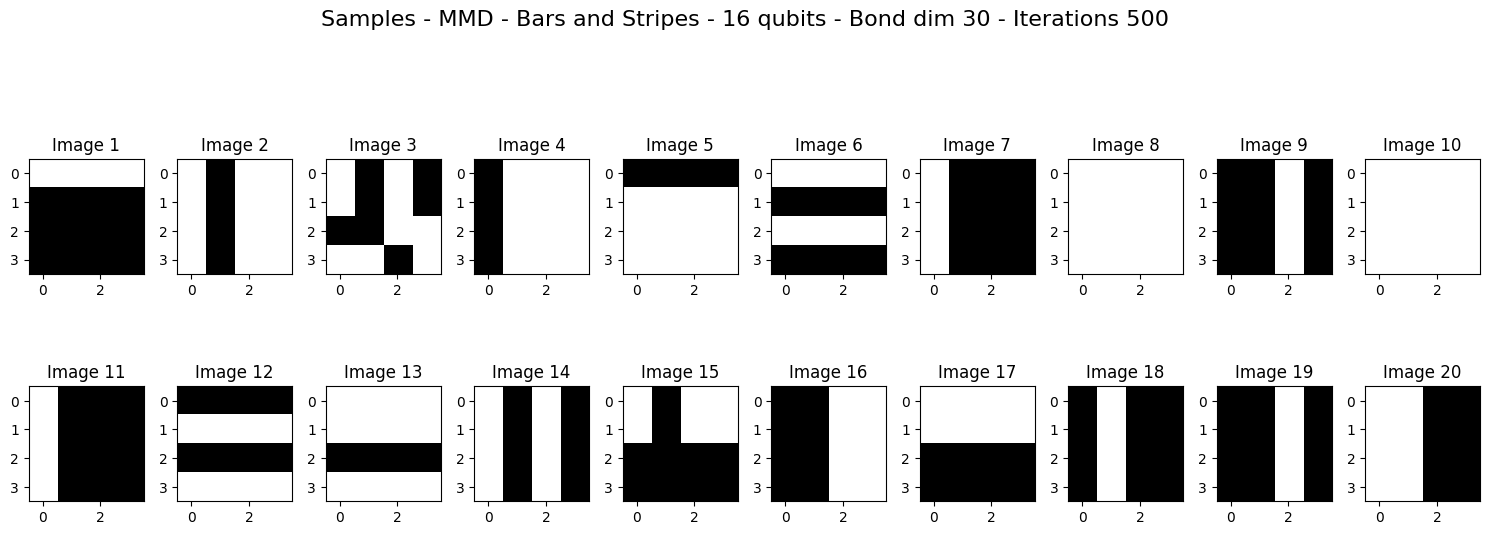

In [ ]:
import matplotlib.pyplot as plt
import time
from src.dataset_utils import plot_binary_data

def plot_BS(loss_function, dataset, num_qubits, bond_dimension, iterations, num_images=20, num_columns = 10):
    
    seed = int(time.time())
    tn = psi_opt
    fig, axes = plt.subplots(2, num_columns, figsize=(15, 6))
    axes = axes.flatten()

    for i, b in enumerate(tn.sample(num_images, seed)):
        arr = np.array(b[0]).reshape((int(np.sqrt(num_qubits)), int(np.sqrt(num_qubits))))
        axes[i].imshow(arr, cmap='gray', interpolation='nearest',vmin = 0, # for binary images
                       vmax = 1)
        axes[i].set_title(f'Image {i+1}')

    plt.suptitle(f'Samples - {loss_function} - {dataset} - {num_qubits} qubits - Bond dim {bond_dimension} - Iterations {iterations}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("samples"+ "_" +loss_function + "_" + dataset + "_" + str(num_qubits) + "q_" + str(bond_dimension) + "b_" + str(iterations) + "i.pdf")
    
plot_BS("MMD", "Bars and Stripes", num_qubits=num_sites, bond_dimension=chi, iterations=iterations)

Cardinality dataset

In [ ]:
from src.dataset_utils import cardinality, bars_and_stripes
#
# cardinality(9, 20, 5)
bars_and_stripes(3, shuffle=False)

array([[[0, 0, 1],
        [0, 0, 1],
        [0, 0, 1]],

       [[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]],

       [[0, 1, 1],
        [0, 1, 1],
        [0, 1, 1]],

       [[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0]],

       [[1, 0, 1],
        [1, 0, 1],
        [1, 0, 1]],

       [[1, 1, 0],
        [1, 1, 0],
        [1, 1, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [1, 1, 1]],

       [[0, 0, 0],
        [1, 1, 1],
        [0, 0, 0]],

       [[0, 0, 0],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [0, 0, 0],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]])

## Loss concentration

In [1]:
import sys
import numpy as np
import quimb.tensor as qtn

In [2]:
import cotengra as ctg
ctg_opt = ctg.ReusableHyperOptimizer(max_time = 20, 
                                     minimize='combo',
                                     slicing_opts={'target_size': 2**40},         # first do basic slicing
                                     slicing_reconf_opts={'target_size': 2**28},  # then advanced slicing with reconfiguring
                                     reconf_opts={'subtree_size': 14},            # then finally just higher quality reconfiguring
                                     parallel=True,
                                     progbar=True,
                                     directory=True)


In [3]:
def nll_loss(psi, htn_data, contraction_method='auto-hq' ):
    
    if contraction_method == 'opt':
        loss = (psi | htn_data).contract(output_inds = ['hyper'], optimize = ctg_opt).data
    elif contraction_method == 'qubitwise':
        for i in range(psi.L):
            loss_tn = loss_tn.contract_tags_(f'I{i}', optimize='auto-hq')
        loss = loss_tn.contract(output_inds = ['hyper'], optimize = 'auto-hq').data 
    else:
        loss = (psi | htn_data).contract(output_inds = ['hyper'], optimize = 'auto-hq').data
    
    return -1. * jnp.mean(jnp.log(jnp.abs(loss) ** 2))

In [ ]:
def mmd_loss(psi, povm_tn, kernel_mpo, htn_data, contraction_method='auto-hq'):
    
    probs_tn = qtn.TensorNetwork([psi, povm_tn,psi.H.reindex_sites('b{}')])

    reindex_map = {f'o{i}': f'op{i}' for i in range(num_sites)}
    model_tn = qtn.TensorNetwork([probs_tn, kernel_mpo, probs_tn.reindex(reindex_map)])
    
    reindex_map_op = {f'k{i}': f'op{i}' for i in range(num_sites)}
    overlap_data_tn = qtn.TensorNetwork([probs_tn,kernel_mpo, htn_data.reindex(reindex_map_op)])

    reindex_map_o = {f'k{i}': f'o{i}' for i in range(num_sites)}
    data_tn = qtn.TensorNetwork([htn_data.reindex(reindex_map_o), kernel_mpo, htn_data.reindex(reindex_map_op)])

    if contraction_method == 'opt':
        hom1 = model_tn.contract(output_inds=[], optimize=ctg_opt)
        mix = overlap_data_tn.contract(output_inds=[], optimize=ctg_opt)
        hom2 = data_tn.contract(output_inds=[], optimize=ctg_opt)
        return hom1.real - 2 * mix.real + hom2.real
    
    if contraction_method == 'qubitwise':
        for i in range(psi.L):
            model_tn = model_tn.contract_tags_(f'I{i}', optimize='auto-hq')
            overlap_data_tn = overlap_data_tn.contract_tags_(f'I{i}', optimize='auto-hq')
            data_tn = data_tn.contract_tags_(f'I{i}', optimize='auto-hq')
        
    hom1 = model_tn.contract(output_inds=[], optimize='auto-hq')
    mix = 2 * overlap_data_tn.contract(output_inds=[], optimize='auto-hq')
    hom2 = data_tn.contract(output_inds=[], optimize='auto-hq')
    
    return hom1.real - 2 * mix.real + hom2.real


In [ ]:
from src.dataset_utils import bars_and_stripes, hypertn_from_data, cardinality
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

num_sites = 100

# POVM MPO
p0 = np.array([[1,0],[0,0]]) 
p1 = np.array([[0,0],[0,1]])
comp_basis_povm = np.array([p0, p1])
tensors = []
for i in range(num_sites):
    t = qtn.Tensor(comp_basis_povm,inds=(f'o{i}', f'k{i}', f'b{i}'), tags = [f'I{i}', 'POVM'])
    tensors.append(t)
povm_tn = qtn.TensorNetwork(tensors)

# Kernel MPO
sigma = 0.5
fact = 1/(2*sigma**2)
kernel_mat = np.array([[1, fact],[fact, 1]])
kernel_mpo = qtn.MPO_product_operator([kernel_mat]*num_sites, upper_ind_id = 'o{}', lower_ind_id = 'op{}', tags = ['KERNEL'])
kernel_mpo = kernel_mpo / kernel_mpo.norm()

# Data hyperTN
bas = bars_and_stripes(int(np.sqrt(num_sites)), shuffle=False, max_samples=1000)
htn_data = hypertn_from_data(bas)

variance_chi_list = []
chi = 20
loss_list = []

print(f"Number of sites: {num_sites}")
print(f"Bond dimension: {chi}")
for i in tqdm(range(100)):
    psi = qtn.MPS_rand_state(num_sites, chi, tags = ['PSI'], dist='uniform')
    loss = mmd_loss(psi, povm_tn, kernel_mpo, htn_data, contraction_method='opt')

In [ ]:
from src.dataset_utils import bars_and_stripes, hypertn_from_data, cardinality
from tqdm.notebook import tqdm


#chi_list = [10, 20, 30, 40, 50]
chi_list = [100]

#num_sites_list = [2**2, 3**2, 4**2, 5**2, 6**2, 7**2, 8**2, 9**2, 10**2]
num_sites_list = [10**2]

variance_list = []

for num_sites in num_sites_list:
    print(f"Number of sites: {num_sites}")

    # # POVM MPO
    # p0 = np.array([[1,0],[0,0]]) 
    # p1 = np.array([[0,0],[0,1]])
    # comp_basis_povm = np.array([p0, p1])
    # tensors = []
    # for i in range(num_sites):
    #     t = qtn.Tensor(comp_basis_povm,inds=(f'o{i}', f'k{i}', f'b{i}'), tags = [f'I{i}', 'POVM'])
    #     tensors.append(t)
    # povm_tn = qtn.TensorNetwork(tensors)

    # # Kernel MPO
    # sigma = 0.5
    # fact = 1/(2*sigma**2)
    # kernel_mat = np.array([[1, fact],[fact, 1]])
    # kernel_mpo = qtn.MPO_product_operator([kernel_mat]*num_sites, upper_ind_id = 'o{}', lower_ind_id = 'op{}', tags = ['KERNEL'])
    # kernel_mpo = kernel_mpo / kernel_mpo.norm()

    # Data hyperTN
    bas = bars_and_stripes(int(np.sqrt(num_sites)), shuffle=False, max_samples=500)
    htn_data = hypertn_from_data(bas)
    
    variance_chi_list = []
    for chi in tqdm(chi_list):
        loss_list = []

        for _ in range(100):
            psi = qtn.MPS_rand_state(num_sites, bond_dim=chi, dist='uniform')
            if num_sites > 9:
                #loss = nll_loss(psi, povm_tn, kernel_mpo, htn_data, contraction_method='opt')
                loss = nll_loss(psi, htn_data, contraction_method='opt')
            else:
                #loss = nll_loss(psi, povm_tn, kernel_mpo, htn_data, contraction_method='opt')
                loss = nll_loss(psi, htn_data)
            loss_list.append(loss)
        variance= np.var(loss_list)
        variance_chi_list.append(variance)
    variance_list.append(variance_chi_list)

Number of sites: 100


100%|██████████| 500/500 [00:00<00:00, 214148.06it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

number of images 2^(n+1)-2

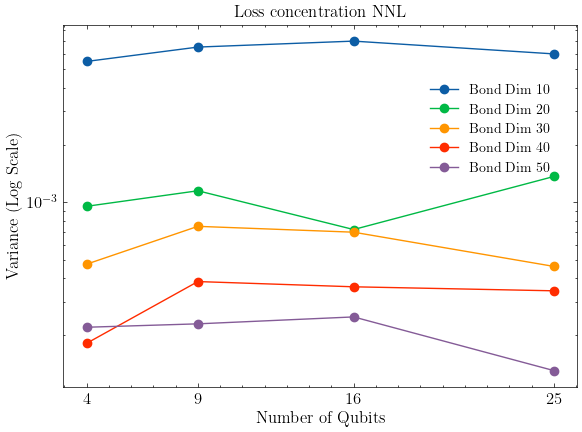

In [ ]:
# Plotting variance for each chi with nqubit on x-axis
import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")

plt.figure(figsize=(6, 6*6/8))
for j, chi in enumerate(chi_list):
    variance_for_chi = [variance_list[i][j] for i in range(len(num_sites_list))]
    plt.plot(num_sites_list, variance_for_chi, marker='o', label=f'Bond Dim {chi}')

plt.yscale('log')
plt.title('Loss concentration NNL', fontsize=12)
plt.xlabel('Number of Qubits', fontsize=12)
plt.ylabel('Variance (Log Scale)', fontsize=12)
plt.xticks(num_sites_list, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=False)
plt.legend(fontsize=10, title_fontsize=10, ncol=1, bbox_to_anchor=(0.83, 0.87), loc='upper center')
plt.tight_layout(pad=1.0)
plt.savefig('loss_concentration_NNL.pdf')
plt.show()

In [3]:
from src.dataset_utils import bars_and_stripes, hypertn_from_data
chi = 100
num_sites = 100
dim = int(num_sites ** 0.5)
psi = qtn.MPS_rand_state(num_sites, chi, dtype=np.complex128)
bas = bars_and_stripes(dim)
htn_data = hypertn_from_data(bas)
htn_data

/afs/cern.ch/user/m/mrobbian/.config/matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /tmp/matplotlib-qebrpqiq because there was an issue with the default path (/afs/cern.ch/user/m/mrobbian/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


TensorNetwork(tensors=100, indices=101)

In [4]:
def nnl_loss(psi, htn_data):
    """
    Calculate the KL divergence between the MPS and the dataset.
    """
    loss = (psi | htn_data).contract(output_inds = ['hyper'], 
                                     optimize = ctg_opt).data
    
    return -1. * np.mean(np.log(np.abs(loss) ** 2))

In [5]:
nnl_loss(psi, htn_data)

np.float64(70.16094346076237)